## Part B: Transfer Learning
Submitted by: Phalguni Rathod | Student No.: R00183770

### Pre-Processing

In [2]:
!nvidia-smi

Mon May  4 15:28:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:

# Colab has two versions of TensorFlow installed: a 1.x version and a 2.x version. 
# Colab currently uses TF 1.x by default
# To enable TF2 execute the following code

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


2.2.0-rc3


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!unzip "/content/gdrive/My Drive/data.h5.zip" -d "./"

Archive:  /content/gdrive/My Drive/data.h5.zip
  inflating: ./data1.h5              


In [6]:
!ls

data1.h5  gdrive  sample_data


In [7]:
import numpy as np
import h5py


def loadDataH5():
    
    with h5py.File('data1.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

trainX, trainY, testX, testY = loadDataH5()


(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)


### General Steps and function defination

Importing the Required Libraries

In [0]:
import os
import gc
import numpy as np
import  matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import tensorflow.keras.layers as L
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import  backend as K
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


Checking the shapes

In [11]:
trainY.shape

(1020,)

In [12]:
np.unique(trainY).shape

(17,)

Defining the batch size, Reading the train-validation data with any augmentation, function defination to show a batch.


In [0]:
# Fixing the batch size
BATCH_SIZE = 64 

In [0]:
# ImageDataGenerator Objects 
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

In [0]:
# Reading the data usinf .flow() as we have already loaded the data in trainX, trainY, testX, testY
train_gen = train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE)
valid_gen = valid_datagen.flow(testX, testY, batch_size=BATCH_SIZE)

In [0]:
# This function is basically used to show first 25 image-label in a image-label batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize = (10,10)) # figure size
  for n in range(25): # Increase the range to plot more/less image-label
      ax = plt.subplot(5,5,n+1) # Fixing the axis
      plt.imshow(image_batch[n][...,::-1].copy()) # Ploting
      plt.title(label_batch[n]) # Giving title
      plt.axis('off') # Switching off the visibilty of axis


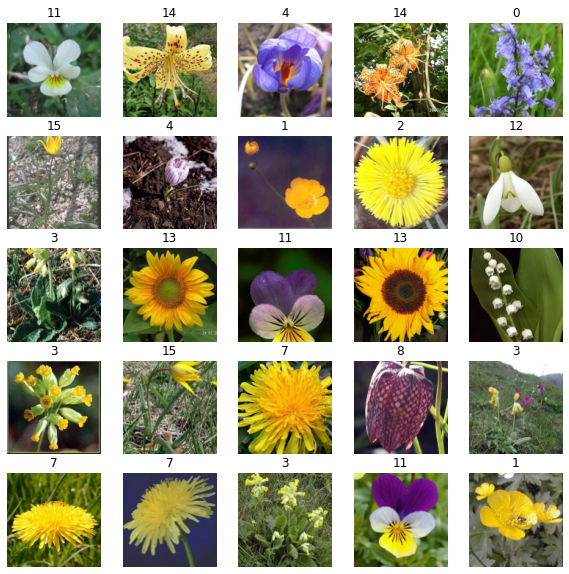

In [76]:
image_batch, label_batch = next(train_gen) # Taking a batch of image-label from training set
show_batch(image_batch, label_batch) # Showing that batch


We have defined functions to plot the validation and training plots


1.   **show_hist(H)**: Plots everything in same graph
2.   **show_hist_sep(H)**: Plots train-val accuracy and train-val loss in different plots



In [0]:
def show_hist(H):

    plt.style.use("ggplot") # Plotting style
    plt.figure() 
    plt.plot(H.history["loss"], label="train_loss") # Ploting training loss
    plt.plot(H.history["val_loss"], label="val_loss") # Plotting validation loss
    plt.plot(H.history["accuracy"], label="train_acc") # Plotting training accuracy
    plt.plot(H.history["val_accuracy"], label="val_acc") # Plotting validation accuracy
    plt.title("Training Loss and Accuracy") # Giving title to the plot
    plt.xlabel("Epoch #") # Label the x axis
    plt.ylabel("Loss/Accuracy") # Label the y axis
    plt.legend() # Giving legends
    plt.show() # Showing the plot

def show_hist_sep(history):
    
    # history for accuracy
    plt.plot(history.history['accuracy']) # Plotting training accuracy
    plt.plot(history.history['val_accuracy']) # Plotting validation accuracy
    plt.title('model accuracy') # Giving title to the plot
    plt.ylabel('accuracy') # Label the y axis
    plt.xlabel('epoch')# Label the x axis
    plt.legend(['train', 'test'], loc='upper left') # Giving legends
    plt.show() # Showing the plot 
    
    # history for loss
    plt.plot(history.history['loss']) # Plotting training loss
    plt.plot(history.history['val_loss']) # Plotting validation loss
    plt.title('model loss') # Giving title to the plot
    plt.ylabel('loss') # Label the y axis
    plt.xlabel('epoch')# Label the x axis
    plt.legend(['train', 'test'], loc='upper left') # Giving legends
    plt.show() # Showing the plot

## Part B-i: Feature Extraction
Focuses on transfer learning. You will be required to investigate and explore the impact of feature extraction.

### Base model: ResNet50
We are using ResNet50 Pre-Trained Model as feature extractor.

**Note:**
We have kept include_top as False, as don't want the FC & Softmax layer at end on the model, we just want the features which we will further use to train the ML Algo.

In [78]:
# Loadig pretrained ResNet50 as base model
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
# summarizing the model
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Compiling the base model, using SGD with lr=0.01

In [0]:
base_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                   optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
                   metrics = ["accuracy"])

Making train and validation prediction on base model and using the outputted vector of 2048-dimension as train & validation features for secondary ML Algorithms. 

In [81]:
train_features = base_model.predict(trainX, verbose=1) # Getting train feature
valid_features = base_model.predict(testX, verbose=1) # Getting validation feature

11/11 [==============================] - 0s 39ms/step


In [82]:
train_features = train_features.reshape(train_features.shape[0], -1) # Reshaping train feature vector
valid_features = valid_features.reshape(valid_features.shape[0], -1) # Reshaping validation feature vector
train_features.shape, valid_features.shape  # Shape of train & validation features

((1020, 32768), (340, 32768))

In [0]:
acc_model = {}

### Secondary model => Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=7, random_state=42)
clf.fit(train_features, trainY)
ps = clf.predict(valid_features)
acc = accuracy_score(testY, ps)
print('Acc Random Forest:', acc)
acc_model['Random Forest'] = acc

Acc Random Forest: 0.7382352941176471


Using Random forests classifier from scikit learn, We get 73% accuracy using depth=7
The base model for feature extraction is ResNetV2-50 


### Secondary model => Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
# %%time
clf = LogisticRegression(random_state=42, n_jobs=-1)
clf.fit(train_features, trainY)
ps = clf.predict(valid_features)
acc = accuracy_score(testY, ps)
print('Accuracy Logistic Regression:',acc)
acc_model['Logistic Regression'] = acc

Accuracy Logistic Regression: 0.9


Using Logistic regression from scikit learn, We get 90% accuracy.

The base model for feature extraction is ResNetV2-50 


### Secondary model => Naive Bayes

In [100]:
from sklearn.naive_bayes import GaussianNB 
# %%time
clf = GaussianNB()
clf.fit(train_features, trainY)
ps = clf.predict(valid_features)
acc = accuracy_score(testY, ps)
print('Accuracy Naive Bayes:',acc)
acc_model['Naive Bayes'] = acc

Accuracy Naive Bayes: 0.6441176470588236


Using GaussianNaive Bayes from scikit learn, We get around 64.41% accuracy using 

The base model for feature extraction is ResNetV2-50 


### Secondary model => KNN

In [101]:
from sklearn.neighbors import KNeighborsClassifier
# %%time
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(train_features, trainY)
ps = clf.predict(valid_features)
acc = accuracy_score(testY, ps)
print('Accuracy KNN :',acc)
acc_model['KNN'] = acc

Accuracy KNN : 0.6411764705882353


Using K-Nearest Neighbour with 7 neighbours from scikit learn, We get around 64.11% accuracy using 

The base model for feature extraction is ResNetV2-50 


### Secondary model => SVC

In [102]:
from sklearn.svm import SVC
# %%time
clf = SVC(kernel = 'linear', C = 1)
clf.fit(train_features, trainY)
ps = clf.predict(valid_features)
acc = accuracy_score(testY, ps)
print('Accuracy SVC:',acc)
acc_model['SVC'] = acc

Accuracy SVC: 0.8764705882352941


Using SVC  from scikit learn, We get around 87.64% accuracy using 

The base model for feature extraction is ResNetV2-50 


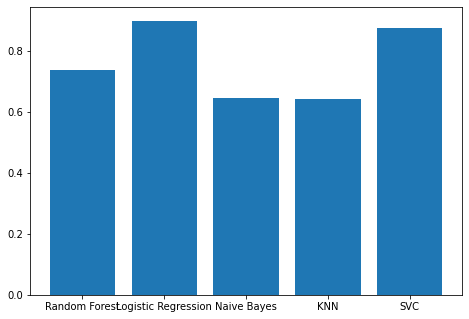

In [104]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(acc_model.keys(),acc_model.values())
plt.show()

## Part B - ii: Fine Tuning

Loading the data 

In [0]:
train_datagen = ImageDataGenerator(
  rotation_range=30,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest",
)
valid_datagen = ImageDataGenerator()

In [0]:
train_gen = train_datagen.flow(trainX, trainY, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = valid_datagen.flow(testX, testY, batch_size=BATCH_SIZE, shuffle=True)

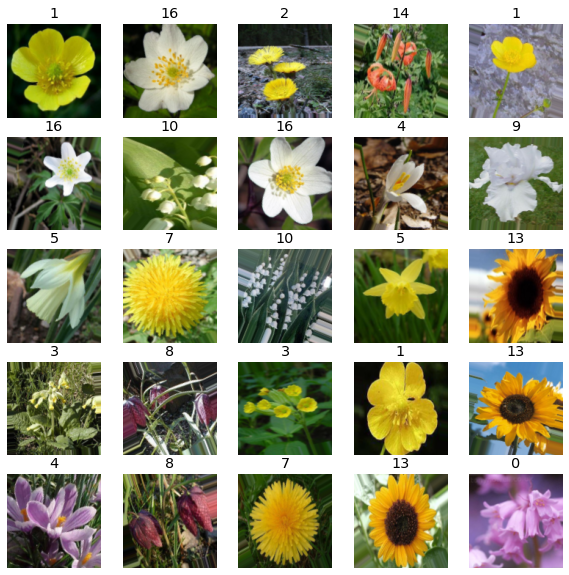

In [45]:
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [19]:
gc.collect()

76

Loading the ResNet50V2 with additional layers as GolbalAveragePooling2D, FC with ReLU and 30% drop probability and last softmax layer with 17 neurons

Phase A - Training Fully Connected Layers

In [0]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
x=base_model.output
x=L.GlobalAveragePooling2D()(x)
x=L.Dense(128,activation='relu')(x)
x=L.Dropout(0.3)(x)
preds=L.Dense(17,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)


Freezing the layers the model and only ket the new layers train.

In [0]:
for layer in model.layers: # Go through each layer
    layer.trainable = False # Freeze each layer
for layer in model.layers[-7:]: # Get the last 6 layers, which are new added
    layer.trainable = True # Unfreeze the layers to make them trainable

In [47]:
# See the summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

### Training the model

In [0]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

In [0]:
# Checkpoints
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.{epoch:02d}-{val_loss:.2f}.hdf5", 
    monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='min', save_freq='epoch')

In [64]:
# Fitting the model
model_hist = model.fit(train_gen,
                       steps_per_epoch = train_gen.n//train_gen.batch_size, 
                        epochs=50,
                        validation_data=valid_gen,
                        validation_steps=valid_gen.n//valid_gen.batch_size, 
                        callbacks = [ckpt]
                       )

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 3.0878 - accuracy: 0.1182
Epoch 00001: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.01-2.34.hdf5
15/15 [==============================] - 6s 378ms/step - loss: 3.0878 - accuracy: 0.1182 - val_loss: 2.3368 - val_accuracy: 0.2875
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 2.4488 - accuracy: 0.2448
Epoch 00002: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.02-1.86.hdf5
15/15 [==============================] - 5s 304ms/step - loss: 2.4488 - accuracy: 0.2448 - val_loss: 1.8618 - val_accuracy: 0.4313
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 2.1592 - accuracy: 0.3525
Epoch 00003: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.03-1.58.hdf5
15/15 [==============================] - 5s 318ms/step - loss: 2.1592 - accuracy: 0.3525 - val_loss: 1.5778 - val_acc

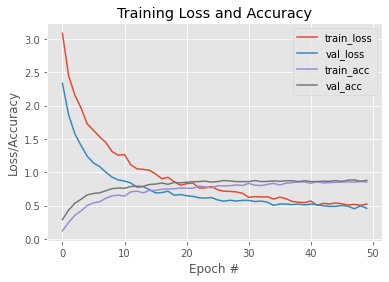

In [65]:
# Plotting Training Loss/Accuracy
show_hist(model_hist)

 Phase B  - Fine Tune Fully Connected Layer and Selected Convolutional Layers

In [66]:
model.trainable = True # Unfreeze the layers for training
trainableFlag = True # Make the flag to check trainable or not
for layer in model.layers: # Take each layer from model
    # if layer.name == 'conv4_block5_3_conv': # Check layer
      trainableFlag = True # Change the train flag
#     layer.trainable = trainableFlag # Make the layer trainable or not, According to trainableFlag
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            metrics=["accuracy"])

model_hist = model.fit(train_gen,
                       steps_per_epoch = train_gen.n//train_gen.batch_size, 
                        epochs=50,
                        validation_data=valid_gen,
                        validation_steps=valid_gen.n//valid_gen.batch_size, 
                        callbacks = [ckpt]
                       )

Epoch 1/50
15/15 [==============================] - ETA: 0s - loss: 1.1709 - accuracy: 0.6381
Epoch 00001: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.01-0.85.hdf5
15/15 [==============================] - 6s 408ms/step - loss: 1.1709 - accuracy: 0.6381 - val_loss: 0.8526 - val_accuracy: 0.7281
Epoch 2/50
15/15 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.7646
Epoch 00002: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.02-0.71.hdf5
15/15 [==============================] - 6s 367ms/step - loss: 0.7218 - accuracy: 0.7646 - val_loss: 0.7106 - val_accuracy: 0.7937
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.8421
Epoch 00003: saving model to /content/gdrive/My Drive/Assignment_data/PartB/ii/base_model_2_weights.03-0.69.hdf5
15/15 [==============================] - 5s 365ms/step - loss: 0.5090 - accuracy: 0.8421 - val_loss: 0.6937 - val_acc

Plot the train-validation accuracy-loss graphs

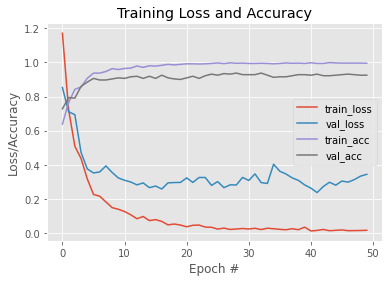

In [67]:
show_hist(model_hist)